In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

# Load Data

In [2]:
car_images = glob.glob('vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/**/*.png')

# Image to HOG

In [3]:
def get_hog_features(
    img, orientation,
    pix_per_cell, cell_per_block,
    vis=False, feature_vec=True):
    """Code duplicated from lectures
    """
    if vis == True:
        (features, hog_image) = hog(
            img,
            orientations=orientation,
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            transform_sqrt=False,
            visualise=vis,
            feature_vector=feature_vec,
            )
        return (features, hog_image)
    else:
        features = hog(
            img,
            orientations=orientation,
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            transform_sqrt=False,
            visualise=vis,
            feature_vector=feature_vec,
            )

        return features

# Extract Features

In [4]:
def convert_colorspace(image, input_space='RGB'):
    converted_image = None

    if input_space != 'RGB':
        if input_space == 'HSV':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif input_space == 'LUV':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif input_space == 'HLS':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif input_space == 'YUV':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif input_space == 'YCrCb':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        converted_image = np.copy(image)

    return converted_image

In [8]:
def extract_features(images, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []

    for file in images:
        image = mpimg.imread(file)
        feature_image = convert_colorspace(image, cspace)

        if hog_channel == 'ALL':
            hog_features = []

            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:, channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        features.append(hog_features)

    return features

# Create a Dataset

In [9]:
# Global Variables
orient = 11
colorspace = 'YUV'
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

In [10]:
car_features = extract_features(car_images, cspace=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)

notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
svc = LinearSVC()
svc.fit(X_train, y_train)

number_of_predictions = 10

print(f"Test Accuracy of SVC = {round(svc.score(X_test, y_test), 4)}")
print(f"Predictions: {svc.predict(X_test[0:number_of_predictions])}")
print(f"For labels: {y_test[0:number_of_predictions]}")

Test Accuracy of SVC = 0.9842
Predictions: [ 0.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
For labels: [ 0.  0.  1.  0.  1.  0.  1.  1.  0.  1.]


# Finding Cars

In [12]:
def find_cars(image, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient,
              pix_per_cell, cell_per_block, spatial_size, hist_bins):

    rectangles = []
    image = image.astype(np.float32) / 255
    image_to_search = image[ystart:ystop,:,:]
    ctrans_tosearch = convert_colorspace(image_to_search, cspace)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(
            ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    if hog_channel == 'ALL':
        channel_1 = ctrans_tosearch[:, :, 0]
        channel_2 = ctrans_tosearch[:, :, 1]
        channel_3 = ctrans_tosearch[:, :, 2]
    else:
        channel_1 = ctrans_tosearch[:,:,hog_channel]

    nxblocks = (channel_1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (channel_1.shape[0] // pix_per_cell)+1  #-1

    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog1 = get_hog_features(channel_1, orient, pix_per_cell, cell_per_block, feature_vec=False)

    if hog_channel == 'ALL':
        hog2 = get_hog_features(channel_2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(channel_3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = np.multiply(yb, cells_per_step)
            xpos = np.multiply(xb, cells_per_step)

            hog_feature_one = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            if hog_channel == 'ALL':
                hog_feature_two = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feature_three = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feature_one, hog_feature_two, hog_feature_three))
            else:
                hog_features = hog_feature_one

            xleft = np.multiply(xpos, pix_per_cell)
            ytop = np.multiply(ypos, pix_per_cell)

            test_prediction = svc.predict([hog_features])

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),
                    (xbox_left +win_draw,ytop_draw+win_draw+ystart)))

    return rectangles

In [13]:
def draw_boxes(image, bounding_boxes, color=(255, 155, 0), thick=6):
    image_copy = np.copy(image)

    for bouding_box in bounding_boxes:
        cv2.rectangle(image_copy, bouding_box[0], bouding_box[1], color, thick)

    return image_copy

In [23]:
def heat_map(heatmap, bounding_boxes):
    for box in bounding_boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

In [25]:
def threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0

    return heatmap

In [30]:
def draw_bounding_box(image, labels):
    rectangles = []

    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bounding_box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rectangles.append(bounding_box)
        cv2.rectangle(image, bounding_box[0], bounding_box[1], (0,0,255), 6)

    return image, rectangles

In [28]:
def process_frame(image):
    search_areas = [
        {'ystart': 400, 'ystop': 464, 'scale': 1.0},
        {'ystart': 416, 'ystop': 480, 'scale': 1.0},
        {'ystart': 400, 'ystop': 496, 'scale': 1.5},
        {'ystart': 432, 'ystop': 528, 'scale': 1.5},
        {'ystart': 400, 'ystop': 528, 'scale': 2.0},
        {'ystart': 430, 'ystop': 560, 'scale': 2.0},
        {'ystart': 400, 'ystop': 600, 'scale': 3.5},
        {'ystart': 460, 'ystop': 660, 'scale': 3.5}]


    rectangles = []

    for area in search_areas:
        rectangles.append(find_cars(image, area['ystart'], area['ystop'], area['scale'],
                                    colorspace, hog_channel, svc, None,
                                    orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist]
    # Apply heatmap
    heatmap_image = np.zeros_like(image[:,:,0])
    heatmap_image = heat_map(heatmap_image, rectangles)

    # Find areas of overlap
    heatmap_image = threshold(heatmap_image, 1)

    # Do a "union" over the heatmap image
    labels = label(heatmap_image)

    image_with_bounding_box, rectangles = draw_bounding_box(np.copy(image), labels)

    return image_with_bounding_box

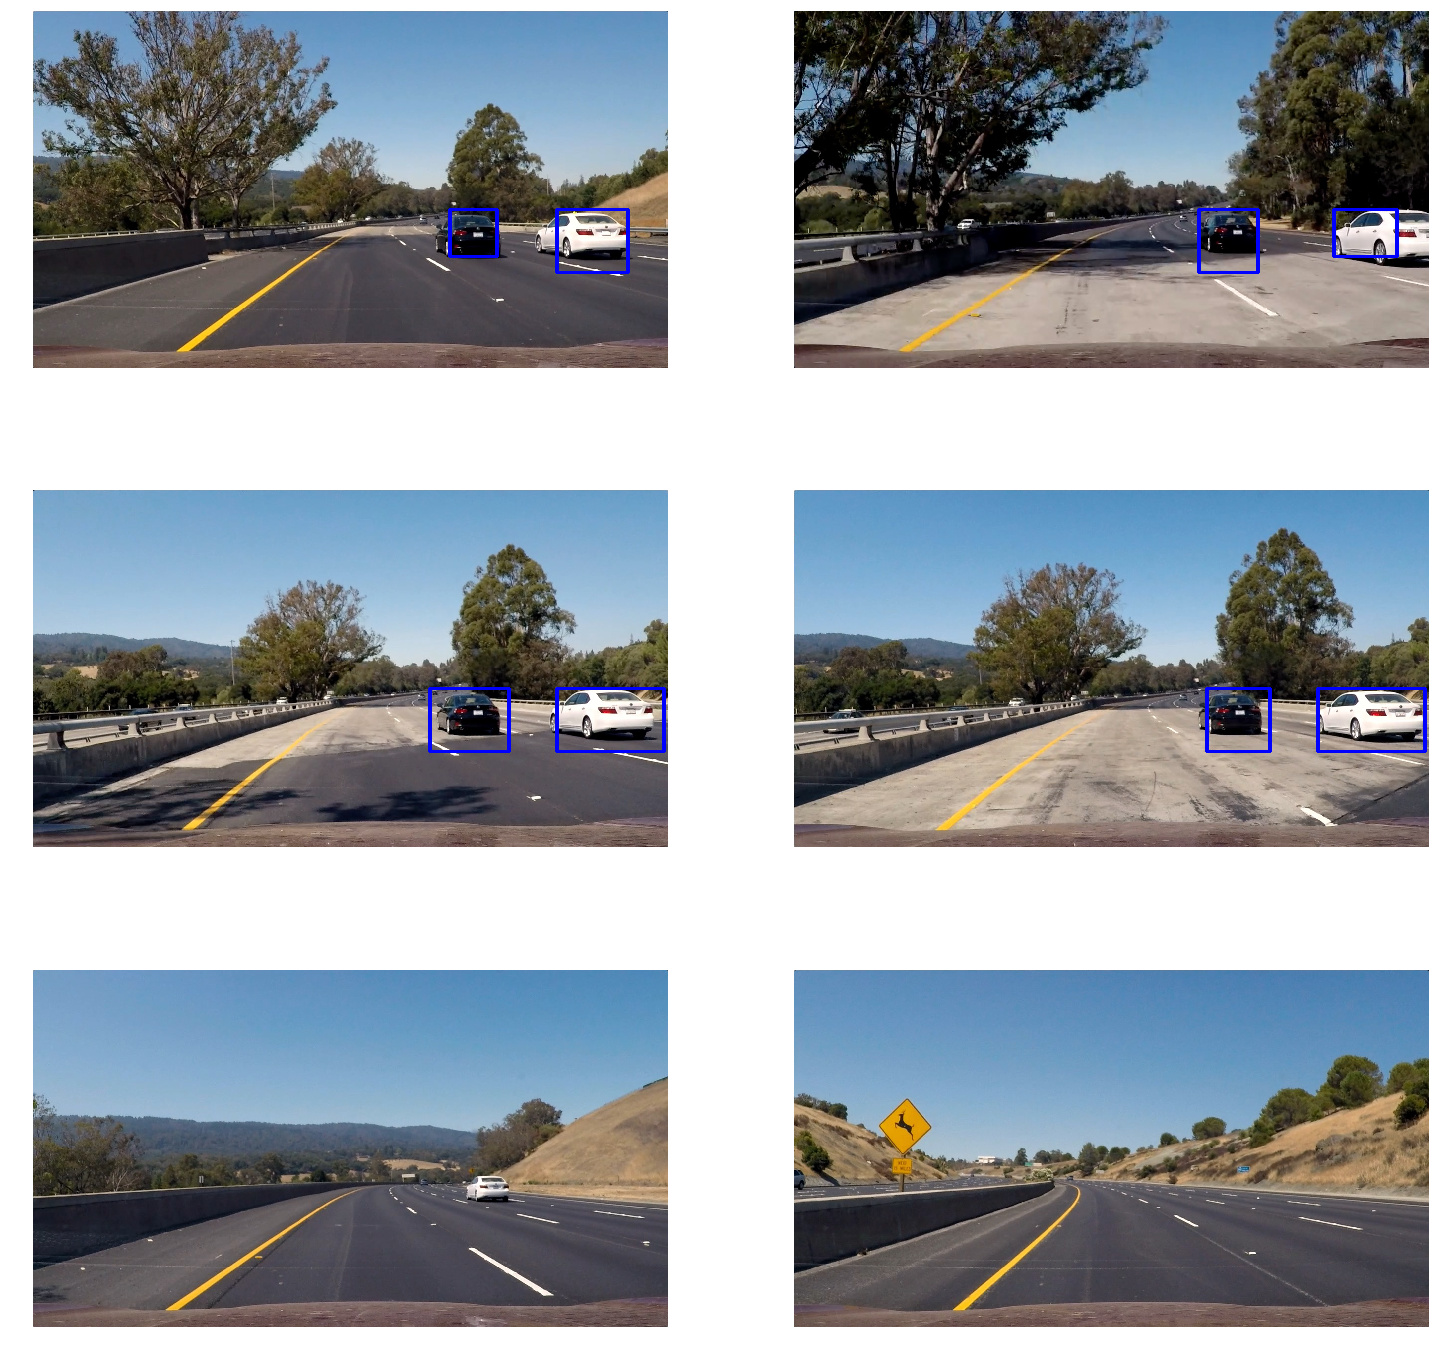

In [29]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(25, 25))
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [31]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


100%|█████████▉| 1260/1261 [09:52<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 9min 22s, sys: 42.3 s, total: 10min 4s
Wall time: 9min 53s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))